# Introduction
Instagram is one of the most popular social media platforms where people can post content and advertise their brands in order to reach a wide audience in addition to people who already "follow" them. So one of the main problems for any "influencer" or brand on instagram is how to reach a wider audience? 

The key is to use hashtags! Hashtags are a way for users to categorize their posts in the hopes that they will show up on peoples' explore pages as similar to what they are interested in (based on who they follow and past behavior). Several articles have written analyses and strategies on how to best use hashtags, but one of the challenges of using instagram is that there is no one-answer as to what hashtags you should be using. 

This model hopes to fix this problem by using collaborative filtering and text-analysis to recommend optimal, personalized hashtags for any picture.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ast import literal_eval
from itertools import chain
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from random import randrange
import gensim
import random
import sklearn
import re
import nltk
import numpy as np
from scipy.spatial.distance import cosine

# Data

This dataset consists of 5324 photos collected from instagram. Photos were collected using the search hashtags:

* cats
* catsofinstagram
* food
* brunch
* naturephotography
* nature
* tech
* mechanicalkeyboard
* fitness

Deep features were collected using a the pre-trained MobileNetV2 convolutional neural network architecture, which was developed by Google. 

Methodology for data collection was based on [this](https://towardsdatascience.com/using-ai-to-automatically-add-hashtags-to-images-d37ff2a42f35) article.

Functions for data collection can be found in data_collection notebook


# Exploratory Data Analysis

In [3]:
# import processed data as a dataframe
df = pd.read_pickle('../web_app/data/update_processed_data.pkl')

In [4]:
# Look at size and features of data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5324 entries, 0 to 5323
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   post_link       5324 non-null   object
 1   image           5323 non-null   object
 2   search_hashtag  5324 non-null   object
 3   tags            5324 non-null   object
 4   likes           5324 non-null   int64 
 5   datetime        5324 non-null   object
 6   pic             5323 non-null   object
 7   deep_features   5323 non-null   object
dtypes: int64(1), object(7)
memory usage: 332.9+ KB


* No null values
* Only numerical column is the likes
* tags = list of tags associated with that observation (post)
* datetime = datetime the post was made. This will be used eventually to delete old data and refresh with new data to keep the recommendations up-to-date
* post_link and image are hyperlinks
* pic = image data represented using EagerTensor type
* deep features = extracted from MobileNetV2 neural network

In [5]:
# look at first 3 obersvations
df.head(3)

,post_link,image,search_hashtag,tags,likes,datetime,pic,deep_features
0,https://www.instagram.com/p/CGaoTcCpg7M/,https://scontent-den4-1.cdninstagram.com/v/t51...,cats,"[cats_of_instagram, catstagramcat, admiremycat...",459,2020-10-16T19:26:16.000Z,"(((tf.Tensor(-0.119607836, shape=(), dtype=flo...","[0.12838979, 0.0, 1.1627966, 0.5287562, 0.0701..."
1,https://www.instagram.com/p/CGapt0jJvtw/,https://scontent-den4-1.cdninstagram.com/v/t51...,cats,"[catsofinstagram, cats_of_instagram, catlife, ...",124,2020-10-16T19:38:36.000Z,"(((tf.Tensor(-0.82549024, shape=(), dtype=floa...","[0.3422525, 0.107019655, 0.65067095, 0.0499435..."
2,https://www.instagram.com/p/CGasg2NJfV2/,https://scontent-den4-1.cdninstagram.com/v/t51...,cats,"[blackandwhitecatsofinstagram, petsofinstagram...",154,2020-10-16T20:03:03.000Z,"(((tf.Tensor(-0.57450986, shape=(), dtype=floa...","[0.0, 0.15019241, 0.37538323, 1.1959279, 0.601..."


In [273]:
df['deep_features']

0       [0.12838979, 0.0, 1.1627966, 0.5287562, 0.0701...
1       [0.3422525, 0.107019655, 0.65067095, 0.0499435...
2       [0.0, 0.15019241, 0.37538323, 1.1959279, 0.601...
3       [0.0, 0.47822708, 2.2018404, 0.20594768, 0.030...
4       [0.01894435, 0.050130617, 1.7625955, 0.0276801...
                              ...                        
5319    [1.0864512, 1.4388124, 0.0, 0.0, 0.0, 0.0, 0.0...
5320    [0.0, 0.0, 0.45173165, 0.9306352, 0.0, 0.08364...
5321    [0.0, 0.7566305, 0.0, 0.6656589, 0.0, 0.434262...
5322    [0.10339018, 0.030953921, 0.23307249, 1.251136...
5323    [0.0, 0.12901062, 2.6773705, 0.903568, 0.17779...
Name: deep_features, Length: 5324, dtype: object

In [6]:
# Print example of tags used on one post
print('This post used {} hashtags\n'.format(len(df['tags'][0])))
print(df['tags'][0])

This post used 27 hashtags

['cats_of_instagram', 'catstagramcat', 'admiremycat', 'ilovemycat', 'catsogram', 'catsofig', 'catscatscats', 'pamperedcats', 'cats_features', 'persiancats', 'cats_of_instworld', 'cats_of_ig', 'bestmeow', 'cats', 'adorablecathttps', 'thedailykitten', 'purr', 'cats_of_day', 'excellent_cats', 'cat', 'catstagrams', 'fluffycat', 'catsuit', 'cats_of_the_globe', 'catstagram', 'cats_of_insta', 'catstgram']


In [7]:
print(type(df['tags'][0]))

<class 'list'>


##### IMPORTANT FOR FUTURE RUNS: 

When I collected the data, I first accidentally saved it as a .csv and then re-opened to before saving as a .pkl file. This turned the 'tags' column, which is supposed to contain a LIST of tags associated with each observation (row), into a string. So we will need to convert this back into a list in order to work with it later.

In the future, updating new data will not require this step

In [ ]:
# DO NOT RUN THIS CELL UNLESS 'TAGS' COLUMN IS TYPE STRING
# Convert 'tags' column into lists

#df.loc[:3747,'tags'] = df.loc[:3747,'tags'].apply(lambda x: literal_eval(x))

Looks like I was able to successfully transform the list of tags back into a list.

# Data Exploration

In [8]:
# Check how many unique search hashtags were used for data collection
print(df.search_hashtag.unique())
print('There were {} hashtags used for the data collection phase'.format(len(df.search_hashtag.unique())))

['cats' 'food' 'catsofinstagram' 'brunch' 'naturephotography'
 'mechanicalkeyboard' 'nature' 'tech' 'fitness']
There were 9 hashtags used for the data collection phase


Text(0.5, 1.0, 'Bar chart of hashtag categories')

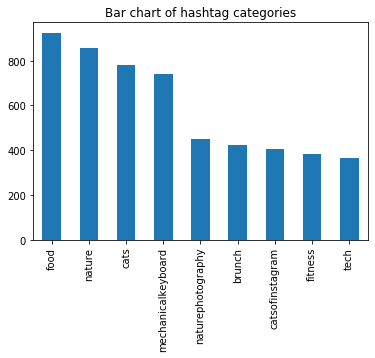

In [9]:
df['search_hashtag'].value_counts().plot.bar()
plt.title('Bar chart of hashtag categories')

* We have the most photos from the #food hashtag
* Unbalanced data doesn't really matter in this project because we are using a pre-trained model and deep features that aren't necessarily trying to fit new data into specific categories, but are simply being used to find the most similar photo -- regardless of what it may be tagged

Text(35.875, 0.5, '# likes per post')

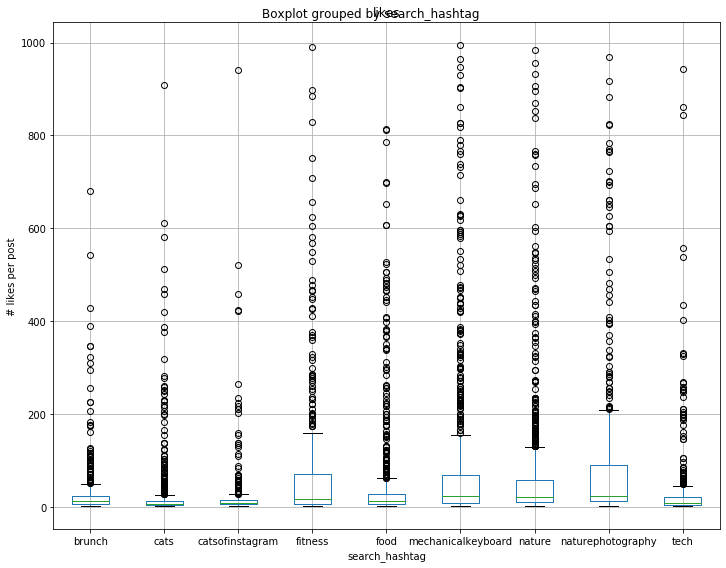

In [10]:
# boxplot for number of likes for each category
df.boxplot(column='likes', by='search_hashtag', figsize=(10,8))
plt.tight_layout()
plt.ylabel('# likes per post')

It seems that #fitness, #mechanicalkeyboard, #nature, and #naturephotography tend to get a higher number of likes, but in general all categories seem to have similar ranges. 

Although it's beyond the scope of this project, it would be interesting to see if the posts getting >800 likes had any correlation to the number of followers an account has, which might add in an innate bias to the number of likes a post can get.

In [11]:
# Craete a list of all tags associated with all photos
all_tags = sorted(list(chain(*df['tags'].tolist())))

print(f'For {len(df)} observations (posts), there are {len(all_tags)} tags used (including repeats)')
print(f'There are {len(set(all_tags))} unique tags used')

For 5324 observations (posts), there are 110462 tags used (including repeats)
There are 31562 unique tags used


In [12]:
# Create a dictionary for the number of times each hashtag appears
tag_count = Counter(all_tags)

(0.1, 10000)

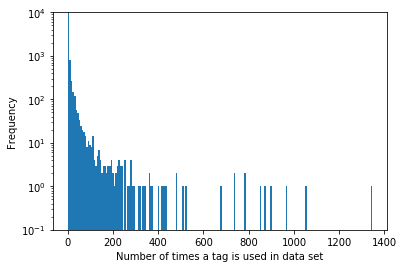

In [13]:
plt.hist(tag_count.values(),bins = 200, density = False, log=True, histtype='stepfilled')
plt.ylabel('Frequency')
plt.xlabel('Number of times a tag is used in data set')
plt.ylim([0,10000])

This histogram of the number of times each unique tag is used shows:
* hashtags that many hashtags are used <200 times in a dataset of 110,462 tags

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


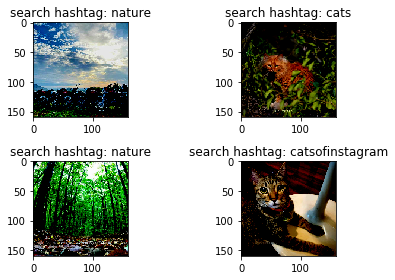

In [17]:
# plot some images
n = 1
for i in range(4):
    plt.subplot(2,2,n)
    idx = randrange(len(df))
    plt.imshow(df['pic'].iloc[idx])
    plt.title(f"search hashtag: {df['search_hashtag'][idx]}")
    n+=1
plt.tight_layout()

As you can see, the search hashtag used to collect the data sets are pretty easy to match up with the photos. However, since instagram allows users to hashtag posts whatever they want, there are also many instances of pictures completely unrelated to the subject it was tagged as. This is especially common with open-ended categories such as #tech, #nature, or #fitness.

In [18]:
# Create new dataframe to hold all of the hashtags and which image (observation index)
# they are associated with. All ratings are set equal to 1 for now.
hashtag_rec_data = []
for i in df.index:
    hashtags = df.loc[i, 'tags']
    for hashtag in hashtags:
        hashtag_rec_data.append(
        {'image_id': i,
         'hashtag': hashtag,
         'count': tag_count[hashtag],
         'likes': df.loc[i,'likes'],
         'adj_likes': df.loc[i,'likes']/len(hashtags),
         'rating': 1})
hashtag_rec_data = pd.DataFrame(hashtag_rec_data)
hashtag_rec_data.tail()

,image_id,hashtag,count,likes,adj_likes,rating
110457,5323,mechanicalkeyboard,735,439,87.8,1
110458,5323,funkeyscomua,2,439,87.8,1
110459,5323,mechanicalkeyboards,251,439,87.8,1
110460,5323,preorder,2,439,87.8,1
110461,5323,keychron,9,439,87.8,1


adjusted likes is the number of likes a post gets divided by the number of tags used on that post. This assumes that every hashtag contributes equally to the popularity of the post -- although we know that this isn't necessarily true.

As you can see, all of the hashtags associated to image id# 5323 have the same number of likes and adjusted likes.

#### This next cell takes a long time to run: approx. 50 mins, so to save time, I have already saved the results as a pickle file.

In [19]:
# scale the adjusted likes to be between 0 and 1. This will be used later
# to calculate "weights" for how popular a hashtag is, and so standardizing
# the data will help decrease bias. Each hashtag will be evaluated independently

# scaler = MinMaxScaler(feature_range = (0,1))
# for hashtag in all_tags:
#     subset = hashtag_rec_data[hashtag_rec_data['hashtag']==hashtag][['adj_likes']]
#     values = scaler.fit_transform(subset).transpose().tolist()[0]
#     indices = subset.index.to_list()
#     for i, value in zip(indices, values):
#         hashtag_rec_data['adj_likes'].iloc[i] = value

hashtag_rec_data = pd.read_pickle('../web_app/data/weighted_tags.pkl')

In [53]:
hashtag_rec_data.head()

,image_id,hashtag,count,likes,adj_likes,rating
0,0,cats_of_instagram,222,459,0.560706,3.029316
1,0,catstagramcat,12,459,0.535957,1.331802
2,0,admiremycat,1,459,0.000000,0.000000
3,0,ilovemycat,64,459,0.978764,4.070567
4,0,catsogram,7,459,1.000000,1.945910


In [20]:
# Check the scaled, adjusted likes for one of the hashtags
# now all 'keychron' uses are weighted from 0 to 1
hashtag_rec_data.loc[hashtag_rec_data['hashtag']=='keychron'][['adj_likes']]

,adj_likes
38489,0.000000
39521,0.003935
105728,0.215123
106468,0.020361
106523,0.278097
108272,0.008232
108350,0.055376
108707,0.016260
110461,1.000000


In [21]:
# aggregate the average number of likes for each hashtag, and the number of occurances
agg_likes = hashtag_rec_data[['hashtag','adj_likes','count']].groupby('hashtag')['adj_likes'].agg(['count','mean','median','min','max'])

In [22]:
# Show the count and some metrics for each hashtag
agg_likes.head(10)

,count,mean,median,min,max
hashtag,,,,,
00s,2,0.500000,0.500000,0.0,1.0
021,2,0.500000,0.500000,0.0,1.0
04,1,0.000000,0.000000,0.0,0.0
040,1,0.000000,0.000000,0.0,0.0
094,1,0.000000,0.000000,0.0,0.0
0942,1,0.000000,0.000000,0.0,0.0
0day,1,0.000000,0.000000,0.0,0.0
1,1,0.000000,0.000000,0.0,0.0
100,3,0.490226,0.470678,0.0,1.0


Plot some histograms to see the distribution of the number of times each hashtag appears as well as the avg and median likes of each hashtag. 

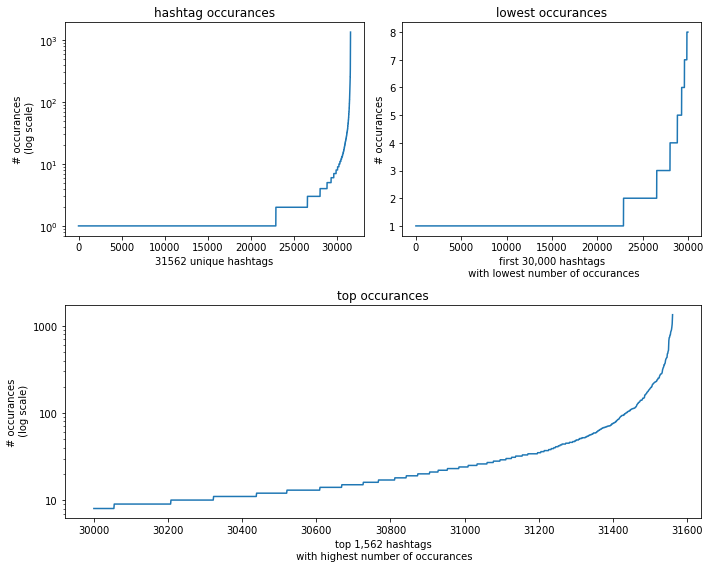

In [23]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.title('hashtag occurances')
plt.plot(sorted(agg_likes['count']))
plt.xlabel(f'{len(agg_likes)} unique hashtags')
plt.ylabel('# occurances\n (log scale)')
plt.yscale('log')

plt.subplot(2,2,2)
plt.title('lowest occurances')
plt.plot(sorted(agg_likes['count'])[:30000])
plt.xlabel('first 30,000 hashtags\n with lowest number of occurances')
plt.ylabel('# occurances')

plt.subplot(2,1,2)
plt.title('top occurances')
plt.plot(np.arange(30000,31562), sorted(agg_likes['count'])[30000:])
plt.xlabel('top 1,562 hashtags\n with highest number of occurances')
plt.ylabel('# occurances\n (log scale)')
plt.yscale('log')
plt.yticks(ticks = [10, 100, 1000], labels = ['10', '100', '1000'])

plt.tight_layout()

From these plots, you can see that the vast majority of hashtags only get used <10 times. 

But how does the number of likes a post get correlate to the frequency of the hashtag being used?

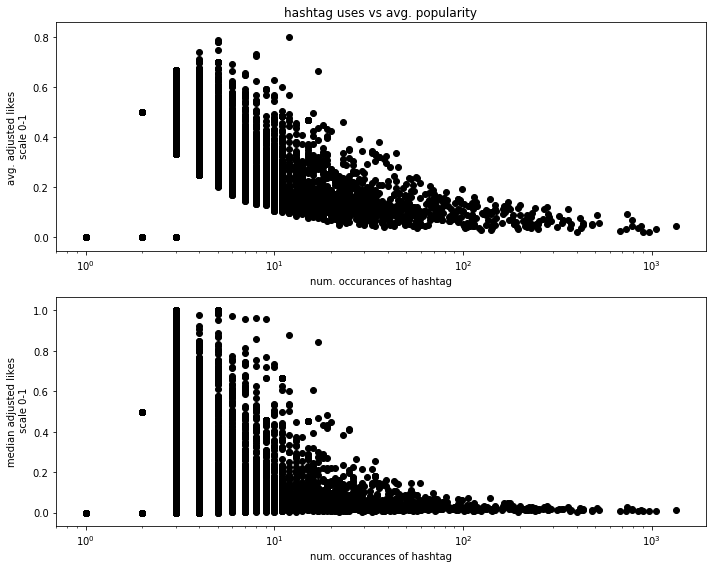

In [24]:
# plot the average likes vs # of occurances
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.scatter(agg_likes['count'], agg_likes['mean'],color='black')
plt.xlabel('num. occurances of hashtag')
plt.ylabel('avg. adjusted likes\n scale 0-1')
plt.title('hashtag uses vs avg. popularity')
plt.xscale('log')
#plt.yticks(ticks = [10, 100, 1000], labels = ['10', '100', '1000'])

plt.subplot(2,1,2)
plt.scatter(agg_likes['count'], agg_likes['median'],color='black')
plt.xlabel('num. occurances of hashtag')
plt.ylabel('median adjusted likes\n scale 0-1')
plt.xscale('log')
#plt.yticks(ticks = [10, 100, 1000], labels = ['10', '100', '1000'])

plt.tight_layout()

* Interestingly the most popular hashtag isn't necessarily getting lots of likes. 
* This might be because it gets many low-like usages?

In [25]:
# Get the number of likes (not adjusted) earned by each post
agg_likes_z = hashtag_rec_data[['image_id','likes']].groupby('image_id').agg(['mean'])['likes']

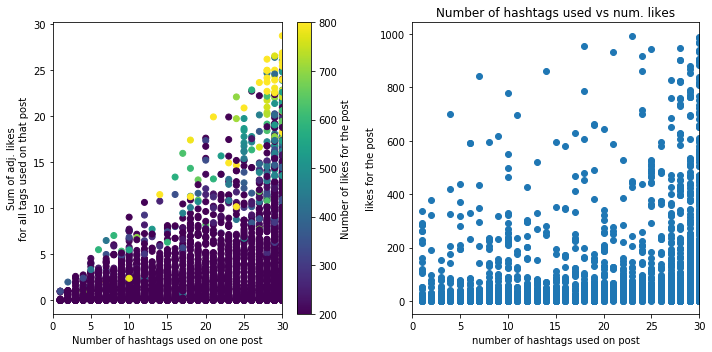

In [268]:
# Aggregate the number of hashtags used on each post, 
# and the sum of all adjusted likes for the hashtags used on that post
agg_likes = hashtag_rec_data[['image_id','adj_likes','likes']].groupby('image_id').agg(['count','sum'])['adj_likes']


plt.figure(figsize=(10,5))
# plot the number of hashtags used on each post vs the sum of the adjusted likes
plt.subplot(1,2,1)
plt.scatter(agg_likes['count'],agg_likes['sum'], c=agg_likes_z['mean'])
plt.xlabel('Number of hashtags used on one post')
plt.ylabel('Sum of adj. likes\nfor all tags used on that post')
# Max hashtags an instagram post can have is 30
plt.xlim([0, 30])
plt.colorbar(label='Number of likes for the post')
plt.clim([200,800])

agg_images = hashtag_rec_data.groupby('image_id').agg(['count', 'mean'])['likes']
# Look at the number of hashtags used on a post and the number of likes it gets
plt.subplot(1,2,2)
plt.scatter(agg_images['count'],agg_images['mean'])
plt.xlabel('number of hashtags used on post')
plt.ylabel('likes for the post')
plt.xlim([0,30])
plt.title('Number of hashtags used vs num. likes')

plt.tight_layout()

* Posts that use the most hashtags have the best chance of getting a high number of likes, however even posts that use 30 hashtags may not get many likes.

There is not a strong relationship between the number of hashtags used on a post and the number of likes (not adjusted), however it does seem that to have a higher chance at getting the most likes, having more hashtags helps

# Build Model

### CBOW
First I will try to use a continuous bag of words (CBOW) model to find similar hashtags based on the posts in the dataset.

CBOW uses surrounding words to try and predict the word in the middle. Therefore, the order of the words does matter, which may pose a problem considering that when users hashtag photos they are often not doing it in any specific order--meaning the order of hashtags listed on a post does not provide any context.

I will provide a solution to this problem later in the notebook, but for now, we'll use the dataset as is.

In [27]:
# Create continuous bag of words model using Word2Vec
model_cbow = gensim.models.Word2Vec(
    df['tags'],
    min_count = 1,
    window = 5,
    sg = 0,
    size = 100,
    hs = 1)

In [28]:
# Look at the top 20 most similar hashtags to 'cats'
print('Top 20 words most similar to #cats')
print(model_cbow.most_similar(positive = ['cats'], topn = 20))
# check similarity of some terms to see how the model is working
print('\n')
print('Similarity of #cats to #fluffy is {}'.format(model_cbow.similarity('cats','fluffy')))
print('Similarity of #cats to #cute is {}'.format(model_cbow.similarity('cats','cute')))
print('Similarity of #cats to #mechanicalkeyboard is {}'.format(model_cbow.similarity('cats','mechanicalkeyboard')))
print('Similarity of #cats to #food is {}'.format(model_cbow.similarity('cats','food')))

Top 20 words most similar to #cats
[('catsofinstagram', 0.9970158338546753), ('cat', 0.9954841136932373), ('kitten', 0.9927405118942261), ('catlife', 0.991955578327179), ('catlover', 0.9899030923843384), ('catlovers', 0.9896396398544312), ('meow', 0.9886224269866943), ('kitty', 0.9881550073623657), ('instacat', 0.9880345463752747), ('catoftheday', 0.9865435361862183), ('catstagram', 0.9853025078773499), ('kittens', 0.9850305318832397), ('cats_of_instagram', 0.9819273948669434), ('gato', 0.9812727570533752), ('adoptdontshop', 0.9797730445861816), ('kittensofinstagram', 0.977155327796936), ('catlove', 0.9766533970832825), ('animallover', 0.9742172360420227), ('catlady', 0.9739364385604858), ('gatos', 0.9723069667816162)]


Similarity of #cats to #fluffy is 0.9597666263580322
Similarity of #cats to #cute is 0.8542251586914062
Similarity of #cats to #mechanicalkeyboard is 0.5496780872344971
Similarity of #cats to #food is 0.4407021999359131


This seems to work pretty well and recognizes that #fluffy and #cute are very strongly related to #cats.

Likewise, it seems #mechanicalkeyboard is very not-similar to #cats, and that #food is slightly more related to #cats than #mechanicalkeyboard

### Skip-gram
An alternative to CBOW is skip-gram, which searches the words commonly surrounding a given word to make predictions.

In [29]:
# create skipgram model
model_skipgram = gensim.models.Word2Vec(
    df['tags'],
    min_count = 1,
    window = 5,
    sg = 1,
    size = 100,
    hs = 1)

# Look at the top 20 most similar hashtags to 'cats'
print('Top 20 words most similar to #cats')
print(model_skipgram.most_similar(positive = ['cats'], topn = 20))
# check similarity of some terms to see how the model is working
print('\n')
print('Similarity of #cats to #fluffy is {}'.format(model_skipgram.similarity('cats','fluffy')))
print('Similarity of #cats to #cute is {}'.format(model_skipgram.similarity('cats','cute')))
print('Similarity of #cats to #mechanicalkeyboard is {}'.format(model_skipgram.similarity('cats','mechanicalkeyboard')))
print('Similarity of #cats to #food is {}'.format(model_skipgram.similarity('cats','food')))

Top 20 words most similar to #cats
[('gato', 0.9715838432312012), ('meow', 0.9714322090148926), ('catlover', 0.970000147819519), ('instacat', 0.9699327349662781), ('chat', 0.9685572385787964), ('catlovers', 0.9671676158905029), ('cutecat', 0.9664610624313354), ('instapet', 0.9649971723556519), ('kittens', 0.9626277089118958), ('catlove', 0.9620124101638794), ('tabbycat', 0.961866021156311), ('cat', 0.9616814255714417), ('gatos', 0.9608261585235596), ('kitten', 0.9605145454406738), ('petlover', 0.959466278553009), ('kittensofinstagram', 0.9592094421386719), ('kitty', 0.9588677287101746), ('catmom', 0.9586567282676697), ('bestmeow', 0.9584254026412964), ('catoftheday', 0.9582998752593994)]


Similarity of #cats to #fluffy is 0.9503399133682251
Similarity of #cats to #cute is 0.7554440498352051
Similarity of #cats to #mechanicalkeyboard is 0.3424239754676819
Similarity of #cats to #food is 0.45898836851119995


The skip-gram algorithm also seems to work well, although comes up with a  different set of most-similar hashtags. It also seems to rate things that are logically far away even lower in similarity than the CBOW algorithm.

The first iteration of the recommender system will use any hashtag in the dataset as a starting point, and then make predictions based on which 10 words are the most similar to the starting point.

In [30]:
# Let's continue with the Skip-gram model
# I like how it seems better at penalizing non-similar words

# get top 10 recommendations for any starting hashtag
# Iterate through each unique hashtag that appears in the dataset
recommendations = []
# iterate through each unique hashtag
for hashtag in sorted(set(all_tags)):
    recommendations.append({
        'hashtag': hashtag,
        'recs': model_skipgram.most_similar(positive = [hashtag], topn = 10)
    }) 
hashtag_recommendations = pd.DataFrame(recommendations)    

Test it out...

In [32]:
print('hashtag: {}'.format(hashtag_recommendations.iloc[90]['hashtag']))
print('top 10 recommended hashtags: {}'.format([tag[0] for tag in hashtag_recommendations.iloc[90]['recs']]))

hashtag: 35mm
top 10 recommended hashtags: ['capture', 'photographylovers', 'artofvisuals', 'nikonphotography', 'цветы', 'macrophotography', 'blackandwhitephotography', 'nikon', 'travels', 'lightroom']


This method works pretty well. As you can see, the starting point hashtag '35mm' is likely related to photography, and other hashtags related to photography and nature came up.

We now have a database, "hashtag_recommendations" that can pull up the 10 most similar hashtags for any given input hashtag (that exists in the database).


### These Word2Vec methods are pretty good at identifying related words. But something I'd really like to incorporate in my model is a ranking system to not only select *similar* hashtags, but also the most *optimal* hashtags -- in other words: I want to recommend hashtags that will garner the most likes. Also, the current system relies on a hashtag as an input, but I want to automate the process as much as possible so the user does not even need to input their own starting point. Moving forward, I will incorperate the photos in the model.

I will also handle the issue of 'context' for the skip-gram method by randomly shuffling the lists of hashtags used for creating the word2vec model.

To optimize my hashtag predictor I will:
1. Use weights of hashtags calculated by evenly distributing the likes on a post (i.e. each hashtag on a post gets 1/n of the likes for n hashtags used on the post). 
2. Then standardize the range of each hashtag to have adjusted likes from 0 to 1. 

(steps 1 and 2 were handled to caclulate the 'adj. likes' score)

3. find 50 most similar hashtags, and instead of simply taking the top 10 based on their similarity, I will take the top 10 based on their adjusted likes score.

In [33]:
# shuffle the tags for each post
for i in range(len(df['tags'])):
    df['tags'].iloc[i] = random.sample(df['tags'][i],len(df['tags'][i]))
# successfully shuffled
print(df['tags'][0]) # compare with original data frame

['thedailykitten', 'catsogram', 'persiancats', 'cats_of_instworld', 'excellent_cats', 'catsofig', 'adorablecathttps', 'cats_features', 'cats_of_ig', 'catstagramcat', 'catscatscats', 'cat', 'fluffycat', 'pamperedcats', 'catstgram', 'ilovemycat', 'admiremycat', 'cats_of_the_globe', 'bestmeow', 'cats_of_day', 'purr', 'cats_of_insta', 'cats', 'catsuit', 'catstagram', 'cats_of_instagram', 'catstagrams']


In [34]:
# test aggregating all of the posts that share a specific hashtag
test = hashtag_rec_data[hashtag_rec_data['hashtag']=='catsogram']
# assign all uses of the same hashtag a rating based on how many likes 
# and how many tags were used on the post
for i in test.index:
    # rating = log(count)*likes
    hashtag_rec_data['rating'].iloc[i] = np.log(hashtag_rec_data['count'].iloc[i])*hashtag_rec_data['adj_likes'].iloc[i]
hashtag_rec_data[hashtag_rec_data['hashtag']=='catsogram']

,image_id,hashtag,count,likes,adj_likes,rating
4,0,catsogram,7,459,1.000000,1.945910
11068,551,catsogram,7,425,0.859919,1.673326
42839,2206,catsogram,7,74,0.136856,0.266310
44147,2266,catsogram,7,6,0.000000,0.000000
46298,2367,catsogram,7,28,0.042096,0.081915
47020,2403,catsogram,7,165,0.324317,0.631092
48579,2482,catsogram,7,91,0.231523,0.450523


The test seems to work well. Apply this rating system to all posts 

In [35]:
for idx in hashtag_rec_data.index:
    # rating = log(count)*adjusted likes 
    # hashtags that only appear once with have a rating equal to 0
    hashtag_rec_data['rating'].iloc[idx] = np.log(hashtag_rec_data['count'].iloc[idx])*hashtag_rec_data['adj_likes'].iloc[idx]

In [36]:
# look at updated data
hashtag_rec_data.head()

,image_id,hashtag,count,likes,adj_likes,rating
0,0,cats_of_instagram,222,459,0.560706,3.029316
1,0,catstagramcat,12,459,0.535957,1.331802
2,0,admiremycat,1,459,0.000000,0.000000
3,0,ilovemycat,64,459,0.978764,4.070567
4,0,catsogram,7,459,1.000000,1.945910


Text(0.5, 0, 'Rating\nlog(n_uses of hashtag)*adj. likes')

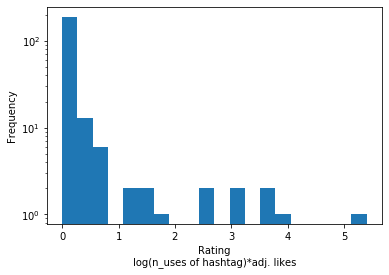

In [37]:
# check distribution of ratings for each hashtag
plt.hist(hashtag_rec_data[hashtag_rec_data['hashtag']=='cats_of_instagram']['rating'], 20)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Rating\nlog(n_uses of hashtag)*adj. likes')

Text(0.5, 1.0, 'Hashtag used 222 times')

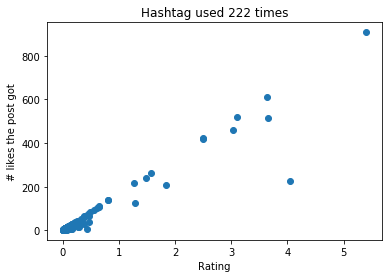

In [46]:
subset = hashtag_rec_data[hashtag_rec_data['hashtag']=='cats_of_instagram']
plt.scatter(subset['rating'], subset['likes'])
plt.xlabel('Rating')
plt.ylabel('# likes the post got')
plt.title('Hashtag used 222 times')

Text(0.5, 1.0, 'Hashtag used 12 times')

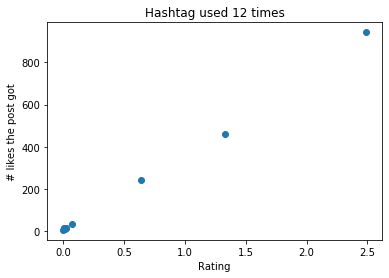

In [45]:
subset = hashtag_rec_data[hashtag_rec_data['hashtag']=='catstagramcat']
plt.scatter(subset['rating'], subset['likes'])
plt.xlabel('Rating')
plt.ylabel('# likes the post got')
plt.title('Hashtag used 12 times')

The "rating" metric I created has a very strong correlation with the number of likes a post gets, which is good.

### Now to continue with improving the model

This current model requires you to have a starting point, or starting hashtag to get recommendations based off of. Instead, it would be more convenient to build a model that was able to try and predict what you are looking for without any input assistance. To do this, I will build a model using the deep features extracted from the photos to recognize photos that are similar to one another, and then filter hashtags based on that smaller subset of photos.

In [47]:
# create training and testing dataset
# test dataset does not have to be large since we will just use it to pull examples
train, test = train_test_split(df, test_size = 0.05, random_state = 2)

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5057 entries, 3268 to 2575
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   post_link       5057 non-null   object
 1   image           5056 non-null   object
 2   search_hashtag  5057 non-null   object
 3   tags            5057 non-null   object
 4   likes           5057 non-null   int64 
 5   datetime        5057 non-null   object
 6   pic             5056 non-null   object
 7   deep_features   5056 non-null   object
dtypes: int64(1), object(7)
memory usage: 355.6+ KB


In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 721 to 2779
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   post_link       267 non-null    object
 1   image           267 non-null    object
 2   search_hashtag  267 non-null    object
 3   tags            267 non-null    object
 4   likes           267 non-null    int64 
 5   datetime        267 non-null    object
 6   pic             267 non-null    object
 7   deep_features   267 non-null    object
dtypes: int64(1), object(7)
memory usage: 18.8+ KB


* test set is 5% of original
* Only usuing to pull some random photos for testing purposes, so a large test size is not needed

In [50]:
# Use KNN to find nearest neighbors based on the deep features
def find_nearest_neighbor(input_features, k=6, df=train):
    rdf = df.copy()
    rdf['dist'] = rdf['deep_features'].apply(lambda x: cosine(x,input_features))
    rdf = rdf.sort_values(by = 'dist')
    return rdf.head(k)

sort photos by popularity as well or maybe try cosine distance and likes to find best pictures to give recommendation on how to alter picture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('findyourpark', 0.9724539518356323), ('syksy', 0.9713066816329956), ('tatry', 0.9705257415771484), ('countryliving', 0.9679677486419678), ('tb', 0.9672640562057495), ('visit_serbia', 0.9671146273612976), ('naturalbeauty', 0.9666032791137695), ('valokuva', 0.9657578468322754), ('instaphotography', 0.9654284119606018), ('oceanlover', 0.9647810459136963)]


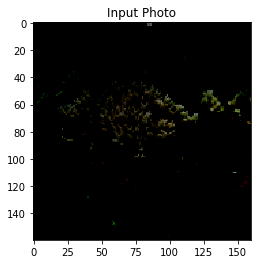

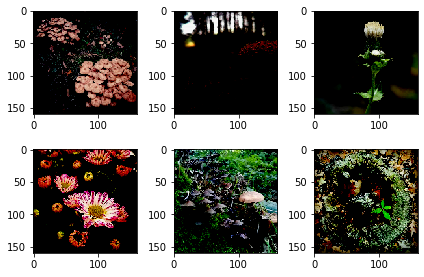

In [233]:
# select random picture from test data set
test_pic = test.sample(n = 1).reset_index(drop=True)
# Plot test picture
plt.figure()
plt.imshow(test_pic['pic'][0])
plt.title('Input Photo')

# Find top 5 most similar pictures based on deep features
matches = find_nearest_neighbor(test_pic['deep_features'][0])
plt.figure()
plt.title('Top 6 Nearest Neighbors (Cosine distance)')
for i,pic in enumerate(matches['pic']):
    plt.subplot(2,3,i+1)
    plt.imshow(pic)
    plt.title('')
    
plt.tight_layout()

# get the best tags
n = 10
nearest_tags = set([tag for tags in matches['tags'] for tag in tags])
# Now let's use the Word2Vec model to find the hashtags for the test picture
similar_tags = model_skipgram.most_similar(positive = nearest_tags, topn = n)
print(similar_tags)

It looks like the hashtags identified are similar to the picture. 

In [258]:
# create a dataframe with the rating for each hashtag in the 6 most similar photos
# using the rating of that hashtag for that specific usage on that photo
data = []
for i in matches.index:
    for tag in matches.loc[i,:]['tags']:
        weight = hashtag_rec_data[(hashtag_rec_data['image_id'] == i) & (hashtag_rec_data['hashtag'] == tag)]['rating'].item()
        print(weight)
        data.append({'tags':tag, 'weight':weight})
weights = pd.DataFrame(data)

2.5649493574615367
0.7528105677366698
0.0
0.775976703970537
1.4481446978374455
0.7539170569186969
0.5148523732975158
0.9864755855819521
1.1983772664405226
0.6248307344906618
0.4704304202490208
0.0
1.3862943611198906
0.0
1.3041662526843576
0.8077395998317511
0.9022654478542483
1.3273288358146749
0.0
0.0
1.0760153446313219
1.4684046031618325
0.0
0.866118169511464
0.0
0.4363600914009966
0.0
0.728765393823308
0.0
0.0
0.0
1.2760286702278099
0.5257367635940429
0.0
0.0
0.0
2.0794415416798357
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.08297907462231553
0.0
0.0
0.0
0.0
0.056454064309484395
0.0
0.0
0.4043358553266345
0.05551765685377814
0.0
0.0
0.0
0.0
0.0
1.0893647527452064
3.0177703649428405
0.9498075164967017
0.8946685749061061
1.0986122886681098
0.0
1.2550431396088735
0.38194679695698297
0.38194679695698297
1.1395294375923355
0.9369032393322676
0.0
2.832288918953742
1.6094379124341003
0.38194679695698297
0.38194679695698297
0.9153844402001241
1.0616195823901453
0.38194679695698297
0.8609366949289678
0.38

In [235]:
weights

,tags,weight
0,wood,2.564949
1,nature,0.752811
2,вид,0.000000
3,watercolor,0.775977
4,sky,1.448145
...,...,...
128,outdoors,0.000000
129,october,0.019229
130,love,0.013508
131,newhampshire,0.000000


In [250]:
# Some photos use the same hashtag, so group by hashtag and take the aggregated weight
# this means hashtags that appear more frequently will have greater importance
summed_weights = weights.groupby('tags').agg(['mean'])['weight'].sort_values(by='mean',ascending=False)
summed_weights.head(10)

,mean
tags,
forest,3.017770
wood,2.564949
sc,2.079442
deer,1.609438
wildlife,1.456615
sky,1.448145
outdoors,1.416144
арт,1.386294
tree,1.327329


In [251]:
# Using more tags as inputs for the similarity step seems to result in
# overall higher mean number of likes
best_tags = set(summed_weights.sort_values(by='mean', ascending=False)[0:50].index)
print(best_tags)

{'likes', 'outdoor', 'sunlight', 'wood', 'forest', 'キャンプ', 'mushrooms', 'intothewoods', 'wilderness', 'hiking', 'sunset', 'explore', 'woodman', 'love', 'art', 'explorepage', 'ig_sweden', 'wildlife', 'view', 'naturelover', 'tree', 'vscocam', 'sc', 'intothewild', 'ハイキング', 'арт', 'woods', 'ブッシュクラフト', 'sky', 'autumn', 'naturephotography', 'yellow', 'アウトドア', 'adventure', 'nature', 'trip', 'amor', 'vsco', 'greenlife', 'fungi', 'outdoors', 'watercolor', 'autumnal', 'woodland', 'microadventure', 'utinaturen', 'friluftsliv', 'weekend', 'walden', 'deer'}


In [252]:
# get the median number of likes each of those tags has
likes = []
for tag in similar_tags:
    likes.append(med_likes.loc[tag[0]]['median'])
    print(f"{tag[0]}, median likes: {med_likes.loc[tag[0]]['median']}")
    
print(f'The average number of median likes these hashtags get is: {np.mean(likes)}')

findyourpark, median likes: 22.0
syksy, median likes: 16.0
tatry, median likes: 28.5
countryliving, median likes: 13.5
tb, median likes: 38.0
visit_serbia, median likes: 9.0
naturalbeauty, median likes: 24.5
valokuva, median likes: 16.0
instaphotography, median likes: 15.0
oceanlover, median likes: 17.0
The average number of median likes these hashtags get is: 19.95


Those results seem fine, but let's try using the rating system I've created to try and weigh the similarity scores of words to get results that are not only semantically similar, but also optimal in terms of the median number of likes they typically get

In [253]:
# get adjusted similar tags
# use only the top 10 best tags from the 6 nearest photos
data = []
similar_tags_update = model_skipgram.most_similar(positive = best_tags, topn = 50)
for tag in similar_tags_update:
    data.append({'hashtag': tag[0],
                 'similarity': tag[1],
                 'weighed_similarity': tag[1]*np.mean(hashtag_rec_data[hashtag_rec_data['hashtag']==tag[0]]['rating']),
                'likes': np.median(hashtag_rec_data[hashtag_rec_data['hashtag']==tag[0]]['likes'])})
top_tags = pd.DataFrame(data)

# get the median number of likes for the top 10 hashtags 
# after applying the weights to the similarity score
adj_top_10 = top_tags.sort_values(by='weighed_similarity', ascending = False).reset_index(drop = True).iloc[0:10]
adj_likes = []
for tag in adj_top_10['hashtag']:
    adj_likes.append(med_likes.loc[tag]['median'])
    print(f"{tag}, median likes: {med_likes.loc[tag]['median']}")

print(f'The average number of median likes these hashtags get is: {np.mean(adj_likes)}')

natureshot, median likes: 92.0
discoverearth, median likes: 61.0
island, median likes: 75.0
nationalgeographic, median likes: 53.5
countryside, median likes: 15.0
roamtheplanet, median likes: 45.0
deutschland, median likes: 58.0
sonnenuntergang, median likes: 55.0
landscape_captures, median likes: 93.0
tourism, median likes: 15.0
The average number of median likes these hashtags get is: 56.25


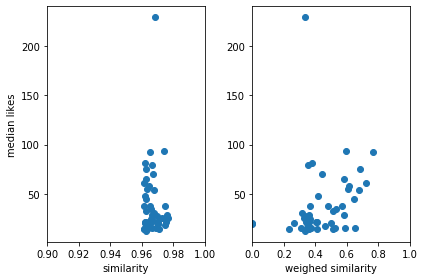

In [244]:
plt.subplot(1,2,1)
plt.scatter(top_tags['similarity'], top_tags['likes'] )
plt.xlim([.9,1])
plt.xlabel('similarity')
plt.ylabel('median likes')
plt.subplot(1,2,2)
plt.scatter(top_tags['weighed_similarity'], top_tags['likes'] )
plt.xlim([0,1])
plt.xlabel('weighed similarity')

plt.tight_layout()

* Using the rating system does change the 10 recommended hashtags, and it seems they on average tend to get much higher number of likes

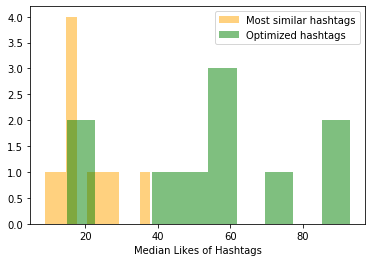

In [242]:
plt.hist(likes,10,color='orange',alpha=0.5)
plt.hist(adj_likes,10,color='green',alpha=0.5)
plt.xlabel('Median Likes of Hashtags')
plt.legend(['Most similar hashtags','Optimized hashtags'])

* The histogram also shows that the optimized hashtags tend to get a higher number of median likes than the hashtags chosen simply based on word-similarity.

# Results
* This project was successful in using a neural network to extract deep features from images in order to find similar images
* Using Word2Vec methods seem very promising in finding similar words to a target word used in hashtags
* Our rating system is a unique way to not only recommend similar hashtags, but also to optimize the number of likes associated with those hashtags

# Future Work
* Expand database. Some of the search hashtags such as fitness, nature, and tech are very open ended and do not contain as targeted photos as #cats. Oftentimes people will tag things that are completely unrelated as nature, tech, and fitness, so having a wider database of images will hopefully help reduce confusion.
* Try other methods to calculate similarity of photos. We tried KNN here, and it seems to work very well.
* Work on adapting the functions to make it easier to update the database.